In [10]:
import sys
sys.path.append("../../src")
import os
import numpy as np
import pickle
from autoencoder_wsindy import full_network
from training_wsindy import create_feed_dictionary, create_feed_dictionary2, eval_model, max_err_heatmap
from sindy_utils import *
from error_utils import *
import tensorflow.compat.v1 as tf
#import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
import matplotlib.pyplot as plt
from time import time
%matplotlib inline
from copy import deepcopy
import random
import subprocess as sp
from sklearn.linear_model import LinearRegression

def get_cmap(n, name='tab20'):
    return plt.cm.get_cmap(name, n)
cmap = get_cmap(10)

In [11]:
# specify which GPU to use
config = tf.ConfigProto(log_device_placement=False, gpu_options=tf.GPUOptions(allow_growth=True,
                                                                              visible_device_list='0'))

## Load the Trained WgLaSDI

In [12]:
data_path = os.getcwd() + '/fig/nDI1/'
save_name = 'burger_2024_07_04_11_29_34'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name
params['config'] = config
# print(params['L'], params['loss_weight_wsindy_x'], params['loss_weight_wsindy_z'])

## Evaluation by One Parameter Case

In [13]:
nt = params['pde']['nt']
nx = params['pde']['nx']
tstop = params['pde']['tstop']
x = np.linspace(-3,3,nx)
dx = 6 / (nx - 1)
dt = tstop / nt 
c = dt / dx
#t = np.linspace(0,tstop,nt+1)
knn = 1

# load testing data
amp_arr = np.array([0.7])
width_arr = np.array([0.9])
test_data = pickle.load(open(f"/usr/workspace/he10/data/1DBurgerEqn/local1_A{amp_arr[0]:.2f}_W{width_arr[0]:.2f}.p", "rb"))
test_data_x = test_data['data'][0]['x']
t = test_data['data'][0]['t']

(1001, 5) (1001, 1001) (1001, 1001)
time: 0.10 s


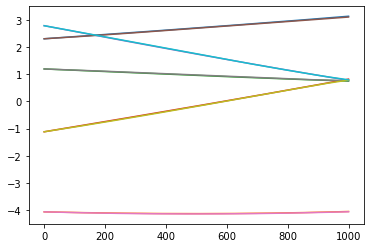

In [14]:
u_decoder,du_decoder,u_sim,du_sim,z_encoder,dz_encoder,z_sim,dz_sim,idx,timer_rom = eval_model(test_data['data'][0], params,
                                                                                               test_data['param'][0], knn=knn,
                                                                                               calc_dz=True, calc_du=True)
u_decoder = u_decoder.squeeze()
time_rom = timer_rom[1:].sum()
print(z_sim.shape, u_sim.shape, u_decoder.shape)
print(f'time: {time_rom:.2f} s')

In [15]:
# max relative error
err_decoder = np.linalg.norm(test_data_x - u_decoder, axis=1) / np.linalg.norm(test_data_x, axis=1)*100
err_sindy = np.linalg.norm(test_data_x - u_sim, axis=1) / np.linalg.norm(test_data_x, axis=1)*100
print(f'max autoencoder error: {err_decoder.max():.2f} %')
print(f'max sindy-decoder error: {err_sindy.max():.2f} %')

max autoencoder error: 1.91 %
max sindy-decoder error: 2.48 %


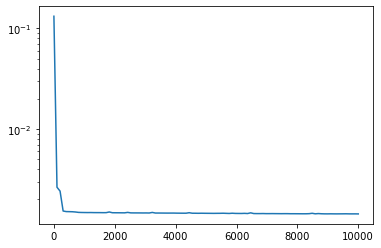

In [16]:
loss = []
for i in range(len(params['training_losses'])):
    loss.append(params['training_losses'][i][0])
xp = np.linspace(1,params['epoch_count'],len(params['training_losses']))
plt.plot(xp,loss)
# plt.ylim([9e-2, 6e-1])
# plt.xlim([3e4, 4.6e4])
# plt.ylim([min(loss), 8e-1])
plt.yscale('log')

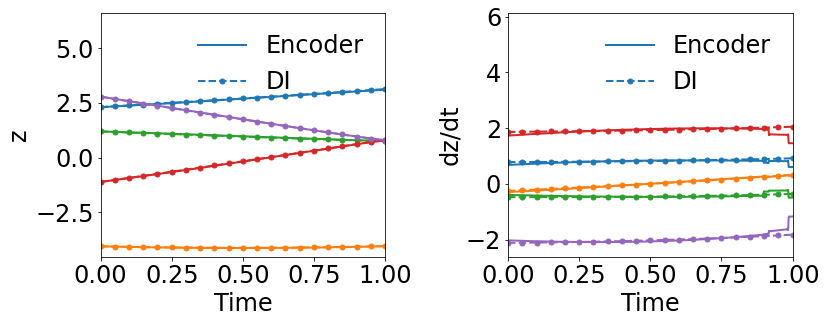

In [17]:
plt.rcParams.update({"font.size": 24,
                     "font.family": "sans-serif"}) # fontsize for figures

fig1 = plt.figure(figsize=(12,5))
line_type = ['-','-*','-.','-^','-s']
idx = np.arange(0,t.size,50)
ax = fig1.add_subplot(121)
for i in range(z_encoder.shape[1]):
    ax.plot(t, z_encoder[:,i], '-', lw=2, c=cmap(i))
    ax.plot(t[idx], z_sim[idx,i], '--o', lw=2, markersize=5, c=cmap(i))
ax.set_xlabel('Time')
ax.set_ylabel('z')
ax.set_xticks(np.linspace(0,t.max(),5))
ax.set_ylim(z_sim.min()*1.1,z_sim.max()+3.5)
ax.tick_params(axis='both', labelsize=24)
ax.legend(['Encoder', 'DI'], loc='upper right', frameon=False, fontsize=24)
ax.set_xlim(t.min(),t.max())

ax = fig1.add_subplot(122)
for i in range(z_sim.shape[1]):
    ax.plot(t, dz_encoder[:,i], '-', linewidth=2, c=cmap(i))
    ax.plot(t[idx], dz_sim[idx,i], '--o', linewidth=2, markersize=5, c=cmap(i))
ax.set_xlabel('Time')
ax.set_ylabel('dz/dt')
ax.set_xticks(np.linspace(0,t.max(),5))
ax.set_xlim(0,t.max())
ax.set_ylim(dz_sim.min()-0.5,dz_sim.max()*3)
ax.tick_params(axis='both', labelsize=24)
ax.legend(['Encoder', 'DI'], loc='upper right', frameon=False, fontsize=24)

plt.tight_layout()
plt.savefig(data_path + f"1Dburger_latent_dynamics.png",bbox_inches='tight')

## Evaluation by the Prescribed Parameter Space

In [9]:
knn = 4
res_name = f'mean'

amp_test = np.linspace(0.7,0.9,21)
width_test = np.linspace(0.9,1.1,21)
params['test_param'] = np.hstack((amp_test.reshape(-1,1), width_test.reshape(-1,1)))

amp_test = params['test_param'][:,0]
width_test = params['test_param'][:,1]
num_case = amp_test.size * width_test.size
max_err = np.zeros([len(amp_test), len(width_test)])
res_norm = np.zeros([len(amp_test), len(width_test)])
sindy_idx = np.zeros([len(amp_test), len(width_test)])
test_data_all = pickle.load(open(f"/usr/workspace/he10/data/1DBurgerEqn//local{num_case}.p", "rb"))

speed_up = 0
count = 0
timer_rom = np.zeros(4)
start_time = time()
for i,a in enumerate(amp_test):
    for j,w in enumerate(width_test):
        print(f"{count+1}/{num_case}: {test_data_all['param'][count]}")
        test_data = {}
        test_data['data'] = [deepcopy(test_data_all['data'][count])]
        test_data['param'] = [deepcopy(test_data_all['param'][count])]
        test_data_x = test_data['data'][0]['x']
        _,_,u_sim,_,_,_,_,_,idx,t_rom = eval_model(test_data['data'][0], params, 
                                                   test_data['param'][0], knn=knn)
        timer_rom += t_rom
        sindy_idx[i,j] = idx+1
        
        # Max error of all time steps
        max_err[i,j] = (np.linalg.norm(test_data_x - u_sim, axis=1) \
                                        / np.linalg.norm(test_data_x, axis=1)*100).max()
        
        # residual norm
        res_norm[i,j] = err_indicator(u_sim, params, err_type=params['err_type'])
        count += 1

end_time = time()
time_rom = timer_rom[1:].sum()/num_case # from Step 2 to 4
time_sim = 3.3 # seconds
speed_up = time_sim / time_rom
print(f'Time taken: {end_time-start_time:.2f} s, {(end_time-start_time)/60:.2f} mins')
print(f'Max relative error: {max_err.max() :.2f} %')
print(f'Average speed up: {speed_up:.2f}')

1/441: [0.7 0.9]
2/441: [0.7  0.91]
3/441: [0.7  0.92]
4/441: [0.7  0.93]
5/441: [0.7  0.94]
6/441: [0.7  0.95]
7/441: [0.7  0.96]
8/441: [0.7  0.97]
9/441: [0.7  0.98]
10/441: [0.7  0.99]
11/441: [0.7 1. ]
12/441: [0.7  1.01]
13/441: [0.7  1.02]
14/441: [0.7  1.03]
15/441: [0.7  1.04]
16/441: [0.7  1.05]
17/441: [0.7  1.06]
18/441: [0.7  1.07]
19/441: [0.7  1.08]
20/441: [0.7  1.09]
21/441: [0.7 1.1]
22/441: [0.71 0.9 ]
23/441: [0.71 0.91]
24/441: [0.71 0.92]
25/441: [0.71 0.93]
26/441: [0.71 0.94]
27/441: [0.71 0.95]
28/441: [0.71 0.96]
29/441: [0.71 0.97]
30/441: [0.71 0.98]
31/441: [0.71 0.99]
32/441: [0.71 1.  ]
33/441: [0.71 1.01]
34/441: [0.71 1.02]
35/441: [0.71 1.03]
36/441: [0.71 1.04]
37/441: [0.71 1.05]
38/441: [0.71 1.06]
39/441: [0.71 1.07]
40/441: [0.71 1.08]
41/441: [0.71 1.09]
42/441: [0.71 1.1 ]
43/441: [0.72 0.9 ]
44/441: [0.72 0.91]
45/441: [0.72 0.92]
46/441: [0.72 0.93]
47/441: [0.72 0.94]
48/441: [0.72 0.95]
49/441: [0.72 0.96]
50/441: [0.72 0.97]
51/441: [0.72 0

In [10]:
print(f'Mean max relative error: {max_err.mean() :.2f} %')

Mean max relative error: 1.78 %


In [11]:
a_grid, w_grid = np.meshgrid(amp_test, width_test)
param_list = np.hstack([a_grid.flatten().reshape(-1,1), w_grid.flatten().reshape(-1,1)])
a_grid, w_grid = np.meshgrid(np.arange(amp_test.size), np.arange(width_test.size))
idx_list = np.hstack([a_grid.flatten().reshape(-1,1), w_grid.flatten().reshape(-1,1)])

idx_param = []
for i,ip in enumerate(params['param']):
    idx = np.argmin(np.linalg.norm(param_list-ip, axis=1))
    idx_param.append((idx, np.array([param_list[idx,0], param_list[idx,1]])))

number of DIs: 16
idx: 0, param: [0.7 0.9]
idx: 147, param: [0.7  0.97]
idx: 273, param: [0.7  1.03]
idx: 420, param: [0.7 1.1]
idx: 7, param: [0.77 0.9 ]
idx: 154, param: [0.77 0.97]
idx: 280, param: [0.77 1.03]
idx: 427, param: [0.77 1.1 ]
idx: 13, param: [0.83 0.9 ]
idx: 160, param: [0.83 0.97]
idx: 286, param: [0.83 1.03]
idx: 433, param: [0.83 1.1 ]
idx: 20, param: [0.9 0.9]
idx: 167, param: [0.9  0.97]
idx: 293, param: [0.9  1.03]
idx: 440, param: [0.9 1.1]


../../src/training.py:704: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


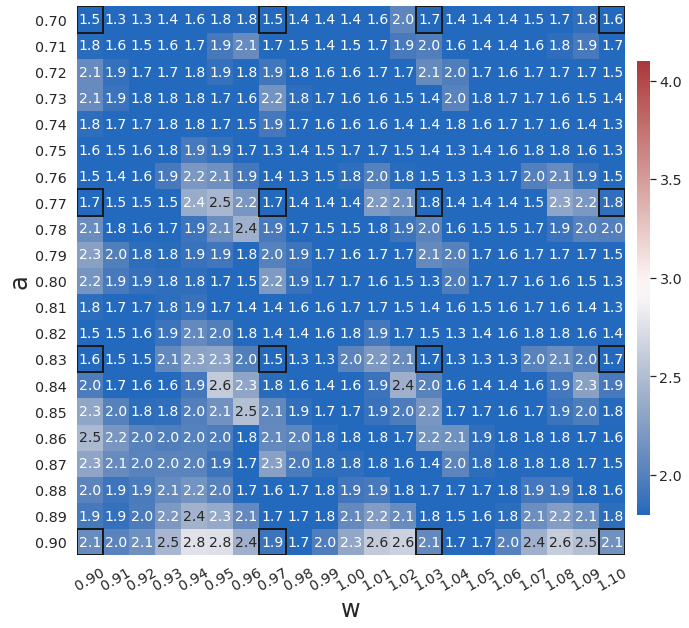

In [14]:
print(f'number of DIs: {len(idx_param)}')
max_err_heatmap(max_err, sindy_idx, params, amp_test, width_test, data_path, idx_list, idx_param,
                xlabel='w', ylabel='a', dtype='float', vmin=1.8, vmax=4.1)